# Segment and vectorise

Using NDVI threshold

## Libraries

In [1]:
import pickle #no idea what this is, but apparently I installed it
import cv2

import os
from os import path
import glob
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...


#check correct environment is being used: parkprov
print(sys.executable)

import rasterio
#from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

from rasterio.mask import mask

import pprint

import folium
import fiona
import pyproj
import shapely as shp
from shapely.ops import linemerge
from shapely.ops import unary_union

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import skimage.io #to read and write images
#import skimage.viewer #to view images; in new window; import matplotlib first - this is shit
import skimage.transform

C:\ProgramData\Anaconda3\envs\parkingcap\python.exe


## Channel order !!!

Look at image specs to see what order the channels are in. For 25cm RGB they are in RGB order and for the CIR 50cm they are NIR, R, G.

### rasterio vs cv2

Both libraries read the data in in the order they are stored BUT cv2 then converts to 'BGR' order. So it expects the image to be in 'RGB' order then swaps the first and third channels.

That is for channels read in order 0,1,2
- 0 -> 2
- 1 -> 1
- 2 -> 0

#### RGB image
For the 25cm RGB images this means cv2 array stores them Blue, Green, Red

#### CIR image
For the 50cm NIR, Red, Green images this means cv2 array stores them Green, Red, NIR

## Load rasters

In [2]:
irg_cg_paths = glob.glob(
    r'C:\Users\Inateck\Documents\parking_provision\off_street_parking\JigsawCroppedNIR\*.tif', recursive=True)
irg_cg_paths[0:5]

['C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedNIR\\M20_osgb1000000254165409.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedNIR\\M20_osgb1000000254165423.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedNIR\\M20_osgb1000000254165546.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedNIR\\M20_osgb1000000254165624.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedNIR\\M20_osgb1000000254165880.tif']

In [3]:
#open one
irg1 = rasterio.open(irg_cg_paths[1])
print("path: ", irg1.name, "\nmode: ", irg1.mode, "\nis closed?: ", irg1.closed
      , "\nband count: ", irg1.count, "\nshape: ", irg1.shape, "\nCRS: ", irg1.crs)

path:  C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedNIR/M20_osgb1000000254165423.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (28, 21) 
CRS:  EPSG:27700


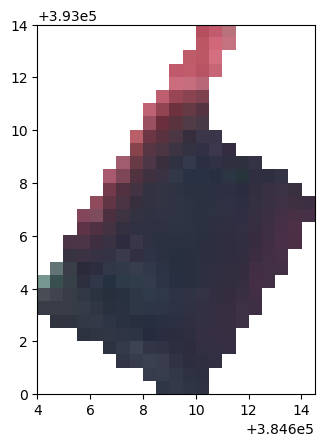

<Axes: >

In [4]:
plot.show(irg1)

In [5]:
irg1_data = irg1.read().astype(float) #convert to float!!!

In [6]:
irg1_data.shape

(3, 28, 21)

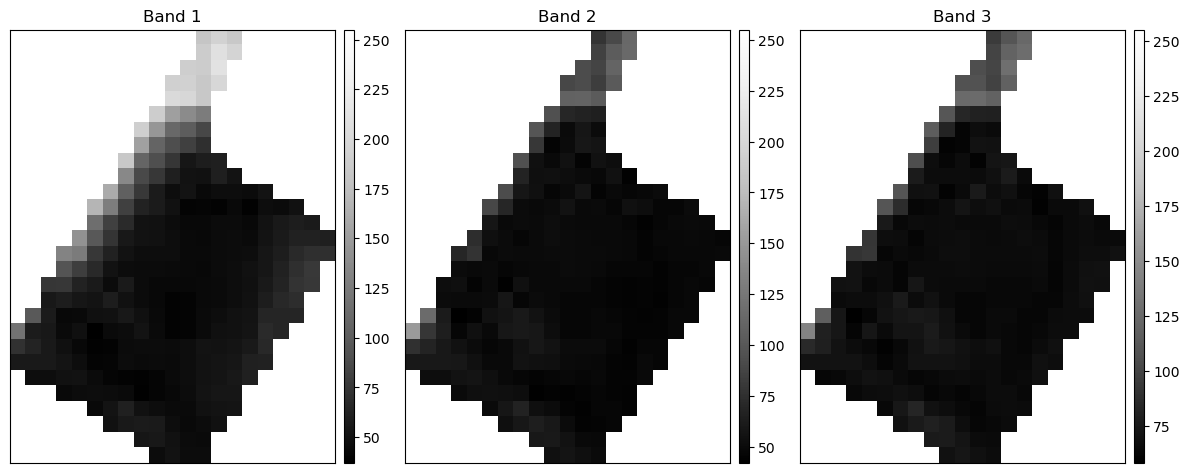

array([<Axes: title={'center': 'Band 1'}>,
       <Axes: title={'center': 'Band 2'}>,
       <Axes: title={'center': 'Band 3'}>], dtype=object)

In [7]:
ep.plot_bands(irg1_data,
              figsize=(12, 6))

In [8]:
rgb_cg_paths = glob.glob(
    r'C:\Users\Inateck\Documents\parking_provision\off_street_parking\JigsawCroppedRGB\*.tif', recursive=True)
rgb_cg_paths[0:5]

['C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedRGB\\M20_osgb1000000254165409.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedRGB\\M20_osgb1000000254165423.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedRGB\\M20_osgb1000000254165546.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedRGB\\M20_osgb1000000254165624.tif',
 'C:\\Users\\Inateck\\Documents\\parking_provision\\off_street_parking\\JigsawCroppedRGB\\M20_osgb1000000254165880.tif']

In [9]:
rgb1 = rasterio.open(rgb_cg_paths[0])
print("path: ", rgb1.name, "\nmode: ", rgb1.mode, "\nis closed?: ", rgb1.closed
      , "\nband count: ", rgb1.count, "\nshape: ", rgb1.shape, "\nCRS: ", rgb1.crs)

path:  C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedRGB/M20_osgb1000000254165409.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (50, 50) 
CRS:  EPSG:27700


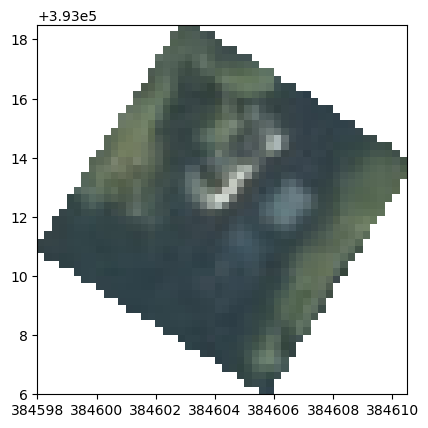

<Axes: >

In [10]:
plot.show(rgb1)

## Create NDVI array for test image

Create np array of NDVI values, one for each pixel, array is same size as image

In [11]:
im = cv2.imread(irg_cg_paths[1]).astype(float)

# Split into 3 channels, remember cv2 order is Green, Red, NIR
Green, Red, NearIR = cv2.split(im)
#if this has read in as B, G, R then 

# Compute NDVI values for each pixel
ndvi = (NearIR - Red) / (NearIR + Red + 0.001) #the extra 0.001 deals with zeros in denominator

In [12]:
im.shape

(28, 21, 3)

In [13]:
type(ndvi)

numpy.ndarray

In [14]:
ndvi.shape

(28, 21)

In [15]:
ndvi[0:3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.39768186, 0.36140224, 0.24160993,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.37226142, 0.33546219, 0.26451528,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.3475165 , 0.36727139, 0.31269253, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

## Map NDVI values for test image

Want to create a new image from these values and assign the metadata from the original

First map NDVI values
- greater than 0 to 255 (vegetation)
- less than or equal to 0 to 0 (non-veg)

In [16]:
tndvi = ndvi.copy()

In [17]:
tndvi[tndvi > 0] = 255
tndvi[tndvi <= 0] = 0

In [18]:
tndvi[0:3, :]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 255., 255., 255.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 255., 255., 255.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        255., 255., 255.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

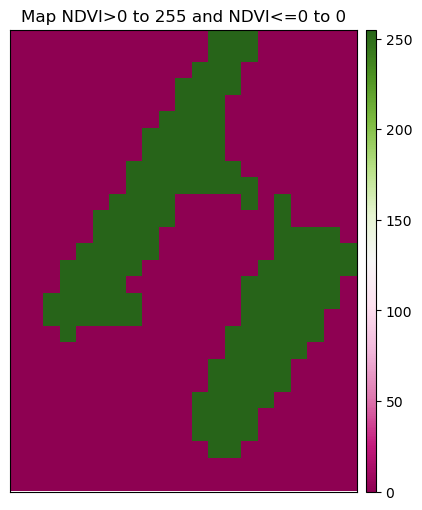

In [19]:
ep.plot_bands(tndvi
              , figsize = (8,6)
              , cmap = 'PiYG'
              , scale = False
              , title = "Map NDVI>0 to 255 and NDVI<=0 to 0")
plt.show()

## Create 3 bands from NDVI values

Split into vegetation, manmade. These will make the Green and Red channels respectively. Collect mask of 255 in all three channels from original 50cm CIR image to use as blue channel for the area external to the garden image.

Want each channel to have only one value in it, and that to be 255.

#### Blue channel - external non-garden space
All this area has NDVI value 0 because the non-garden area was set to white, 255 in each channel, but don't want to confuse with 'natural' NDVI 0 values. I make the assumption here that any white (255, 255, 255) is external to the garden, and no white occurs in the image.

- Compare Green, Red, NIR to 255
- True & True & True = True (only True outcome of AND logic table)

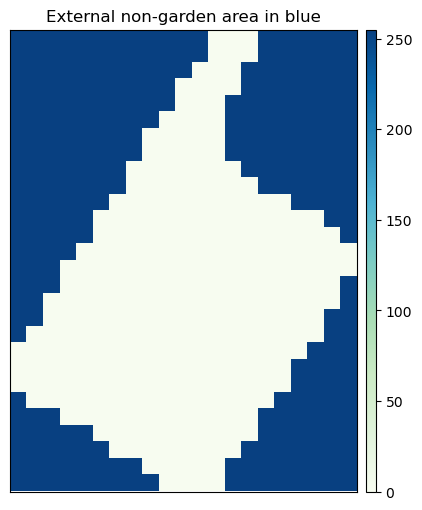

In [20]:
ext = (Green == 255) & (Red == 255) & (NearIR == 255)
ext = 255 * ext #255 * True = 255; auto-converts to int True -> 1, False -> 0

ep.plot_bands(ext
              , figsize = (8,6)
              , cmap='GnBu'
              , scale=False
              , title="External non-garden area in blue")
plt.show()

#### Green channel - vegetation

Make veg (>0) 255 and everything else 0

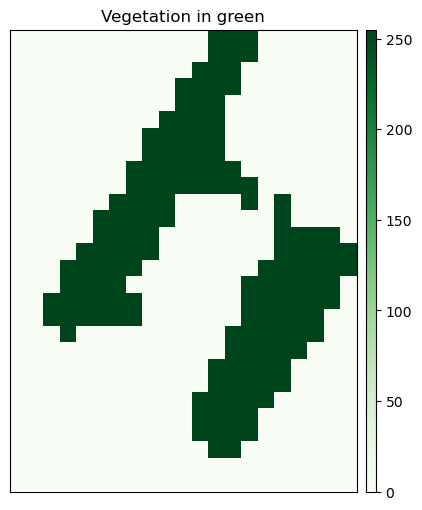

In [21]:
veg = ndvi.copy()
veg[veg > 0] = 255
veg[veg <= 0] = 0

ep.plot_bands(veg
              , figsize = (8,6)
              , cmap='Greens'
              , scale=False
              , title="Vegetation in green")
plt.show()

#### Red channel - manmade surface (excluding external area)

Create by 
- create an array of the correct size with all values 255
- subtract veg and ext

veg and ext do not overlap since all external area has NDVI value 0, and only NDVI values greater than 0 are counted as vegetation. 

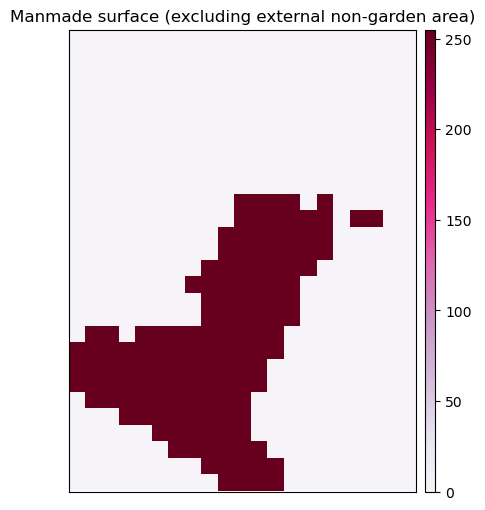

In [23]:
mms = 255 * np.ones(shape = (veg.shape[0], veg.shape[1]), dtype=int)
mms = mms - ext - veg

ep.plot_bands(mms
              , figsize = (8,6)
              , cmap='PuRd'
              , scale=False
              , title="Manmade surface (excluding external non-garden area)")
plt.show()

## Stack the 3 channels & plot 

- stack in rasterio or in cv2?

### Use cv2 (BGR) order & (h,w,3) shape

In [24]:
a = np.dstack((ext, veg, mms))

In [25]:
a.shape

(28, 21, 3)

### Convert to shape (3, h, w) and RGB order

In [26]:
b = np.vstack((mms, veg, ext))
print(b.shape)
print(b)
newb = np.reshape(b, (3, veg.shape[0], veg.shape[1]), 'C' )
print(newb.shape)

(84, 21)
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
(3, 28, 21)


In [27]:
#Bottom right hand slither 2 pixels high and 8 across should have something from each channel
#perfect - this is correct, still indexing from top left corner
newb[0:3, 18:20, 26:35]

array([], shape=(3, 2, 0), dtype=float64)

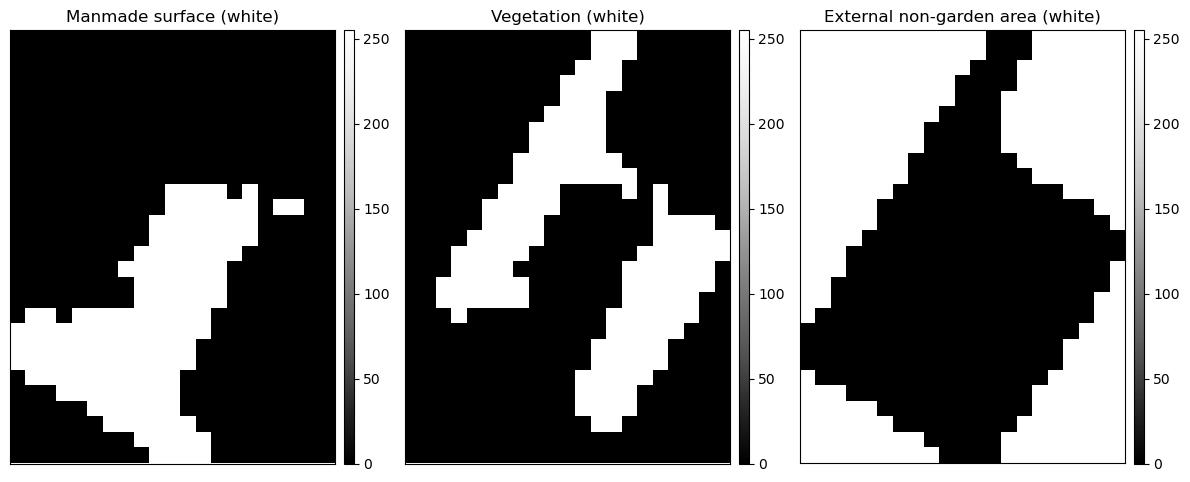

array([<Axes: title={'center': 'Manmade surface (white)'}>,
       <Axes: title={'center': 'Vegetation (white)'}>,
       <Axes: title={'center': 'External non-garden area (white)'}>],
      dtype=object)

In [28]:
ep.plot_bands(newb
             , title = [ 'Manmade surface (white)'
                         , 'Vegetation (white)'
                         , 'External non-garden area (white)']
             )

## Take newb and give it the meta data from irg1

###  for test image

In [64]:
newb.shape

(3, 28, 21)

In [65]:

irg1.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 21,
 'height': 28,
 'count': 3,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(0.5, 0.0, 384604.0,
        0.0, -0.5, 393014.0)}

In [66]:
filename = "../data/test_new_image.tif"
with rasterio.open(filename, mode = "w", **irg1.meta) as dest:
                dest.write(newb.astype(np.uint8))

RasterioIOError: Attempt to create new tiff file '../data/test_new_image.tif' failed: No such file or directory

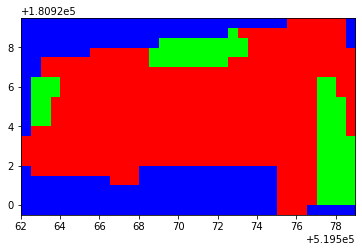

In [31]:
#read back in to test
test = rasterio.open("../data/test_new_image.tif")
plot.show(test)

#CRS is correct

## Load cropped garden polygons

### Check corresponding vector overlays as expected

It does and the polygon is entirely inside the pixel, because when I jigsawed the cropped garden images I chose to include a puxel if it was 'touching' the polygon at any point, not only if it is entirely inside. Hence the blue, external garden area pixel are entirely outside the oringal polygon.

In [29]:
#get toid from filename
irg1_toid = irg_cg_paths[0][-20:-4]
print("path:", irg_cg_paths[0])
irg1_toid

path: C:\Users\Inateck\Documents\parking_provision\off_street_parking\JigsawCroppedNIR\M20_osgb1000000254165409.tif


'1000000254165409'

In [30]:
cg = gpd.read_file(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\CroppedGarden\M20CroppedGardens.shp")

In [33]:
#Load cropped gardens
#cg: cropped gardens
#read in as strings
#cg = pd.read_csv("../data/cropped_gardens.csv"
                 , dtype={'gdnTOID': object, 'geometry': object})
#convert WKT strings to geometry
#cg['geometry'] = cg['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
#cg = gpd.GeoDataFrame(cg, crs="EPSG:27700", geometry="geometry")

In [31]:
print(type(cg))
cg.crs
cg.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,gdnTOID,geometry
0,osgb1000000254165409,"POLYGON ((384605.698 393006.188, 384598.248 39..."
1,osgb1000000254165423,"POLYGON ((384604.118 393003.480, 384604.850 39..."
2,osgb1000000254165504,"POLYGON ((384959.662 392993.767, 384961.023 39..."
3,osgb1000000254165546,"POLYGON ((384683.173 393001.086, 384683.364 39..."
4,osgb1000000254165569,"POLYGON ((384510.747 392996.767, 384509.550 39..."


In [32]:
#make list of cropped garden toids
cgTOID_list = cg.gdnTOID.tolist()


In [33]:
cgTOID_list[0]

'osgb1000000254165409'

C:\ProgramData\Anaconda3\envs\parkingcap\Lib\site-packages\geopandas\plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


NameError: name 'test' is not defined

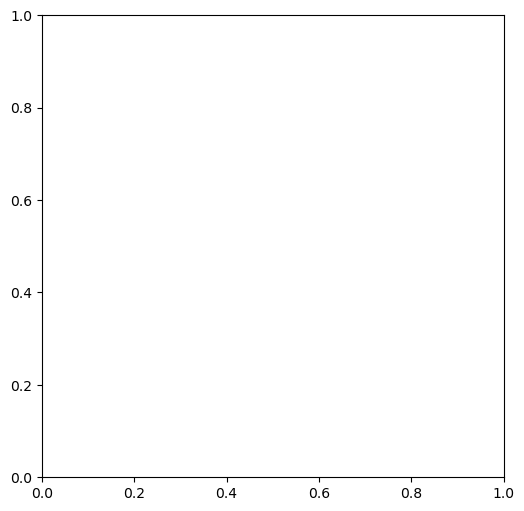

In [72]:
base = cg[cg.gdnTOID == irg1_toid].plot(color = 'green', alpha = 0.5, figsize = (8,6))

plot.show(test, ax = base)


## Segment all cropped garden images and write 

In [74]:
for i in np.arange(len(irg_cg_paths)):
    
    im = rasterio.open(irg_cg_paths[i]) #im is source
    im_data = im.read().astype(float) #assign data array to object & convert to float
    
    # Split into 3 channels, remember rasterio order is  NIR, Red, Green
    NIR = im_data[0]
    RED = im_data[1]
    GRN = im_data[2]
    
    # Compute NDVI values for each pixel with NIR [0], and Red [1]
    ndvi = (NIR - RED) / (NIR + RED + 0.001) #the extra 0.001 deals with zeros in denominator

    #Create EXTernal garden area band - 255 in blue channel
    EXT = (GRN == 255) & (RED == 255) & (NIR == 255)
    EXT = 255 * EXT #255 * True = 255; auto-converts to int True -> 1, False -> 0

    #Create VEGetation area band - 255 in green channel
    VEG = ndvi.copy()
    VEG[VEG > 0] = 255
    VEG[VEG <= 0] = 0
    
    #Create MANmade surface area band - 255 in red channel
    MAN = 255 * np.ones(shape = (VEG.shape[0], VEG.shape[1]), dtype=int)
    MAN = MAN - EXT - VEG

    #Combine these 3 channels; reshape to (3, height, width) shape and RGB order
    #seg: segmented data
    seg = np.vstack((MAN, VEG, EXT))
    seg = np.reshape(seg, (3, VEG.shape[0], VEG.shape[1]), 'C' )
    
    #create filename to write new tif image to
    filename = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/SegmentedImages/" + irg_cg_paths[i][-27:]
    
    #write image and assign original CRS meta data
    with rasterio.open(filename, mode = "w", **im.meta) as dest:
                dest.write(seg.astype(np.uint8)) #must be uint8

## Plot some to compare segmented image to original NIR and RGB

In [34]:
toid = cgTOID_list[1]
grid = 'M20'

In [35]:
rgb_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/" + grid + "_" + toid + '.tif'
rgb_path

'C:/Users/Inateck/Documents/parking_provision/off_street_parking/M20_osgb1000000254165423.tif'

In [36]:
print(len(cgTOID_list))

2296


In [87]:
grid = 'M20'

for i in np.arange(5):
    
    #get gdn TOID
    toid = cgTOID_list[i]
    
    #create RGB, IRG and segmented image paths
    rgb_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedRGB/" + grid + "_" + toid + '.tif'
    irg_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedNIR/" + grid + "_" + toid + '.tif'
    seg_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/SegmentedImages/" + '20' + "_" + toid + '.tif'
 
    #open each
    rgb = rasterio.open(rgb_path)
    irg = rasterio.open(irg_path)
    seg = rasterio.open(seg_path)
    
    #plot
    plot.show(rgb, title = "TOID:" + toid)
    plot.show(irg, title = "TOID:" + toid)
    plot.show(seg, title = "TOID:" + toid)


SyntaxError: invalid syntax (3707650315.py, line 23)

## Create mask & vectorise test image

Use Steve Kingston example code: dft-rio-features-shapes.ipynb

https://rasterio.readthedocs.io/en/latest/topics/features.html

Use the MAN (Red/Manmade surface) channel equal to 255  for the mask

In [37]:
#adapt SK example code

# create path to segmented image
grid = '20'
toid = cgTOID_list[10]
seg_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/SegmentedImages/" + grid + "_" + toid + '.tif'


with rasterio.open(seg_path) as seg:
  MAN = seg.read(1) #collect first/red channel as MANmade surface array
  mask = MAN == 255 #create mask where MAN is 255
  results = ( #dictionarise results
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) #s:shape, v:value
        in enumerate(
            rasterio.features.shapes(
                MAN #image to vectorize
                , mask = mask #only vectorize where mask is true
                , transform = seg.transform))) #transform axes to BNG location
  
geojson = list(results)

#convert to GeoDataFrame and set CRS to BNG
gdf1 = gpd.GeoDataFrame.from_features(geojson, crs = "EPSG:27700")

#add TOID column 
gdf1['TOID'] = toid

#maybe want to combine many polygons into multipolygon????
#drop tiny polygons
#what about polygons with holes in?
gdf1.head()

,geometry,raster_val,TOID
0,"POLYGON ((384572.000 393033.500, 384572.000 39...",255.0,osgb1000000254166360
1,"POLYGON ((384577.000 393035.000, 384577.000 39...",255.0,osgb1000000254166360


<Axes: >

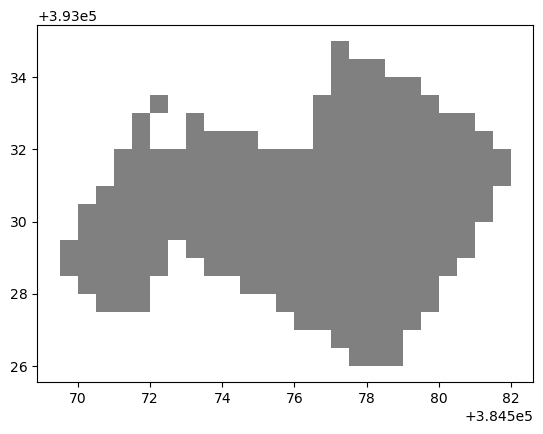

In [38]:
gdf1.plot(color = 'grey')

### Plot together with cropped garden shape and 25cm image

In this image the tree partly obscures the car. The shadow area is counted as manmade.

https://rasterio.readthedocs.io/en/latest/topics/features.html
https://realpython.com/python-opencv-color-spaces/

<Axes: >

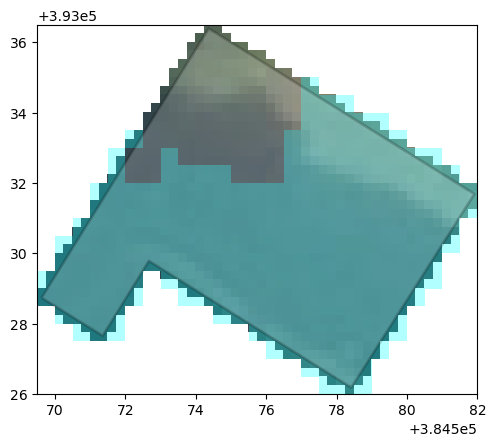

In [39]:
# plot together with croped garden shape and image

base = gdf1.plot(color = 'cyan', alpha = 0.3)
cg[cg['gdnTOID'] == toid].plot(ax = base
                               , color = 'white', alpha = 0.2, edgecolor = 'black', linewidth = 2)

#get rgb image
rgb_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedRGB/" + 'M20' + "_" + toid + '.tif'
rgb = rasterio.open(rgb_path)

plot.show(rgb, ax = base)

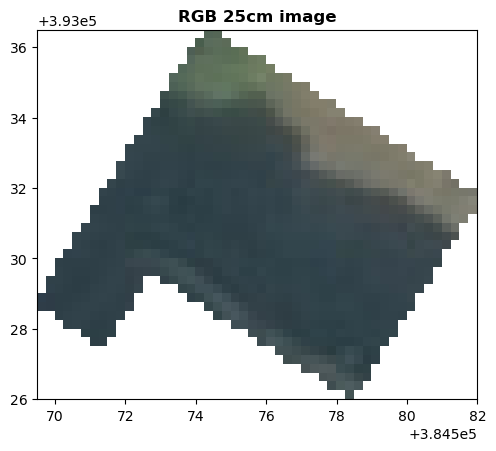

<Axes: title={'center': 'RGB 25cm image'}>

In [40]:
plot.show(rgb, title = "RGB 25cm image")

## Vectorise all manmade surface segmented shapes, tidy & write

This will result in a single dataframe containing more than one polygon per garden toid. Clean these up

- Find area of each, remove those with area less than 11.52m^2
- interesect with roadside edge linestring that goes with and drop any that do not intersect
- find length of intersection with roadside edge polygon and drop any shorter than 2.4m 
- for polygons with holes get the area of each hole and look at a histogram of it, look at the distribution and decide a cut off point to fill holes under a certain area.

In [42]:
#this took about 40 seconds to run for 1328 images
#get segmented image paths
seg_paths = glob.glob(
    r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/SegmentedImages/*.tif", recursive=True)

#init list to hold individual gdfs
gdfs_list = []

#for seg_path in seg_paths:
#for seg_path in seg_paths[0:5]:
    
for seg_path in seg_paths:
    #get grid and TOID from image_path
    grid = '20'
    toid = seg_path[-24:-4]
    
    with rasterio.open(seg_path) as seg:
      MAN = seg.read(1) #collect first/red channel as MANmade surface array
      mask = MAN == 255 #create mask where MAN (red channel) is 255
      results = ( #dictionarise results
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) #s:shape, v:value
            in enumerate(
                rasterio.features.shapes(
                    MAN #image to vectorize
                    , mask = mask #only vectorize where mask is true
                    , transform = seg.transform))) #transform axes to BNG location
  
    geojson = list(results)

    #convert to GeoDataFrame and set CRS to BNG
    gdf = gpd.GeoDataFrame.from_features(geojson)
    #add TOID column 
    gdf['TOID'] = toid
    
    #append gdf to list
    gdfs_list.append(gdf)
    
    #end for loop
    
#concatenate list of gdfs into one gdf
#vms: vectorised manmade surface
vms = pd.concat(gdfs_list, ignore_index=True)


In [43]:
vms.head()

,geometry,raster_val,TOID
0,"POLYGON ((384607.000 393016.500, 384607.000 39...",255.0,osgb1000000254165409
1,"POLYGON ((384607.500 393016.000, 384607.500 39...",255.0,osgb1000000254165409
2,"POLYGON ((384602.500 393008.000, 384602.500 39...",255.0,osgb1000000254165409
3,"POLYGON ((384612.500 393008.500, 384612.500 39...",255.0,osgb1000000254165423
4,"POLYGON ((384609.000 393009.000, 384609.000 39...",255.0,osgb1000000254165423


In [129]:
print(seg_path[-24:-4])

osgb1000000254173595


### Drop raster_val col

In [44]:
vms = vms.drop(['raster_val'], axis=1)

### Checked for polygon validity & fix if necessary

https://stackoverflow.com/questions/20833344/fix-invalid-polygon-in-shapely

- did not realise until ppp15 when I tried to do an intersection on these polygons that some are invalid - self-intersecting
- the link shows a method of fixing this by adding a buffer of 0, to rewrite as a valid polygon
- sometimes the buffer 0 method does not work, where there is a 'bowtie' intersection the buffer 0 method may keep the small part and not the main part of the polygon.
- check resultant polygon areas to see what's happened

Self intersecting areas are places where two vertices of the polygon overlap, occurs only on the edge of the polygon, or the edge of a hole.

In [45]:
invalid_pol_toids = vms[ vms['geometry'].is_valid == False ]['TOID']

In [46]:
len(invalid_pol_toids)

0

In [47]:
len(list(set(invalid_pol_toids)))

0

In [48]:
for toid in invalid_pol_toids[0:3]:
    vms[ vms['TOID'] == toid].plot(color = 'red', alpha = 0.5)

In [49]:
#overwrite geom with buffer = 0
vms2 = vms.copy(deep = True)

vms2['geometry'] = (
    vms2['geometry'].apply(lambda x: x.buffer(0))
)

In [50]:
inv_pol_toid = vms2[ vms2['geometry'].is_valid == False ]['TOID']

In [51]:
len(list(set(inv_pol_toid)))

0

In [52]:
#check areas are equal
vms['area'] = (
    vms['geometry'].apply(lambda x: x.area)
)

#check areas are equal
vms2['area'] = (
    vms2['geometry'].apply(lambda x: x.area)
)

In [53]:
vms.shape[0] == vms2.shape[0]

True

In [54]:
sum( vms['area'] == vms2['area'] ) == vms.shape[0]

True

#### Looks good, proceed to correct invlaid polygons in vms

In [55]:
vms['geometry'] = (
    vms['geometry'].apply(lambda x: x.buffer(0))
)

In [56]:
vms = vms.drop(['area'], axis = 1)

In [58]:
vms.head()

,geometry,TOID
0,"POLYGON ((384607.000 393016.500, 384607.500 39...",osgb1000000254165409
1,"POLYGON ((384607.500 393016.000, 384608.000 39...",osgb1000000254165409
2,"POLYGON ((384602.500 393008.000, 384603.000 39...",osgb1000000254165409
3,"POLYGON ((384612.500 393008.500, 384613.500 39...",osgb1000000254165423
4,"POLYGON ((384609.000 393009.000, 384611.000 39...",osgb1000000254165423


In [59]:
inv_pol_toid = vms[ vms['geometry'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))
#good apparently, no invalid polygons anymore.

0

### Reorient interior linear rings (holes) in polygons, else they don't plot right!

shapely.geometry.polygon.orient(polygon, sign=1.0)
Returns a **properly oriented copy of the given polygon**. The signed area of the result will have the given sign. A sign of 1.0 means that the coordinates of the product’s exterior ring will be oriented counter-clockwise and the interior rings (holes) will be oriented clockwise. 

Sign of -1 presumably does the reverse, clockwise exterior and anticlockwise interiors?


In [60]:
#new_geometry_series = dataframe.geometry.apply(polygon.orient,args=(1)) #or -1
vms['geometry'] = (
    vms['geometry'].apply(lambda x: shp.geometry.polygon.orient(x, 1))
)

In [147]:
#check holes are there
vms.query('TOID == "5000005138038971"').plot(color = 'red')

UndefinedVariableError: name 'TOID' is not defined

In [61]:
#check for polygon validity again
inv_pol_toid = vms[ vms['geometry'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))

#good

0

In [62]:
#write 
vms.to_file(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Vector\ManmadeSurfaces\VectorisedManmadeSurfaces.shp", index=False)

In [63]:
vms.shape
#looks like nearly 2 polygons per toid on average

(5536, 2)

In [64]:
vms.head()

,geometry,TOID
0,"POLYGON ((384607.000 393016.500, 384607.000 39...",osgb1000000254165409
1,"POLYGON ((384607.500 393016.000, 384607.500 39...",osgb1000000254165409
2,"POLYGON ((384602.500 393008.000, 384602.500 39...",osgb1000000254165409
3,"POLYGON ((384612.500 393008.500, 384612.500 39...",osgb1000000254165423
4,"POLYGON ((384609.000 393009.000, 384609.000 39...",osgb1000000254165423


In [66]:
vms.crs

## Plot VMS with cropped garden polygon, roadside edge & RGB image

Plot a few toids together with 

- vectorised manmade surface in pink
- cropped garden vector in white with black edge 
- RGB image for reference
- roadside edge linestring for reference

### Read in roadside_linestrings.csv

This gpd file was created in 02APGBJigsaw and was used to crop the gardens

In [67]:
rs_ls = gpd.read_file(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Roadside\Roadside_Linestring.shp")

In [82]:
#rs_ls = pd.read_csv("../data/roadside_linestrings.csv"
#                 , dtype={'gdnTOID': object, 'rsTOID': object, 'geometry': object})
#convert WKT strings to geometry
#rs_ls['geometry'] = rs_ls['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
#rs_ls = gpd.GeoDataFrame(rs_ls, crs="EPSG:27700", geometry="geometry")

In [68]:
#check for validity
inv_pol_toid = rs_ls[ rs_ls['geometry'].is_valid == False ]['gdnTOID']
len(list(set(inv_pol_toid)))
#good all valid

0

In [69]:
rs_ls.head()

,gdnTOID,rsTOID,geometry
0,osgb1000000254165409,osgb5000005107990281,"LINESTRING (384603.050 393018.500, 384610.500 ..."
1,osgb1000000254165423,osgb5000005107990281,"LINESTRING (384610.500 393013.800, 384611.100 ..."
2,osgb1000000254165880,osgb5000005107990281,"LINESTRING (384622.100 393004.650, 384625.450 ..."
3,osgb1000000254166360,osgb5000005107990281,"LINESTRING (384574.350 393036.400, 384581.900 ..."
4,osgb1000000254166361,osgb5000005107990281,"LINESTRING (384581.900 393031.700, 384588.900 ..."


In [70]:
cg.head()

,gdnTOID,geometry
0,osgb1000000254165409,"POLYGON ((384605.698 393006.188, 384598.248 39..."
1,osgb1000000254165423,"POLYGON ((384604.118 393003.480, 384604.850 39..."
2,osgb1000000254165504,"POLYGON ((384959.662 392993.767, 384961.023 39..."
3,osgb1000000254165546,"POLYGON ((384683.173 393001.086, 384683.364 39..."
4,osgb1000000254165569,"POLYGON ((384510.747 392996.767, 384509.550 39..."


In [71]:
vms.head()

,geometry,TOID
0,"POLYGON ((384607.000 393016.500, 384607.000 39...",osgb1000000254165409
1,"POLYGON ((384607.500 393016.000, 384607.500 39...",osgb1000000254165409
2,"POLYGON ((384602.500 393008.000, 384602.500 39...",osgb1000000254165409
3,"POLYGON ((384612.500 393008.500, 384612.500 39...",osgb1000000254165423
4,"POLYGON ((384609.000 393009.000, 384609.000 39...",osgb1000000254165423


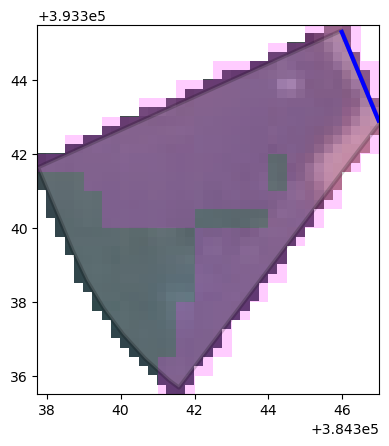

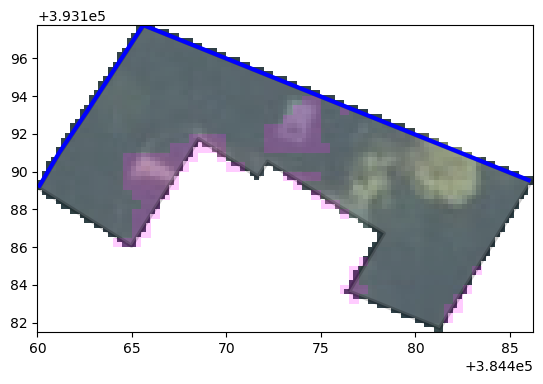

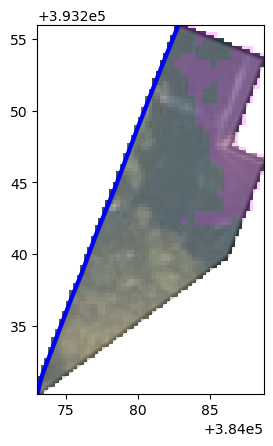

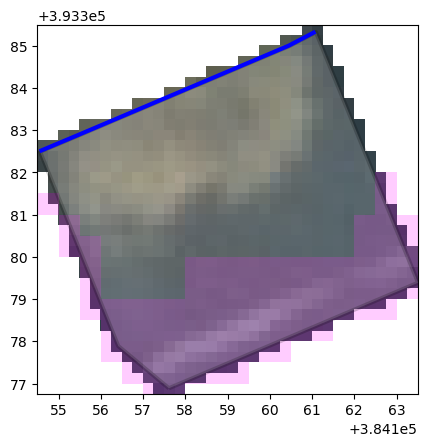

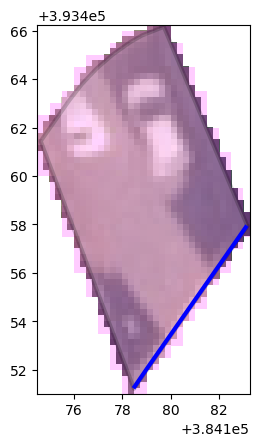

In [72]:
#generate 5 random ints from the range of images
randint = np.random.randint(low = 0, high = 2000, size = 1)

grid = 'M20'

#cgTOID_list[80:85]
for toid in cgTOID_list[randint[0]:(randint[0]+5)]:
    #plot vectorise manmade surface
    base = vms[vms['TOID'] == toid].plot(color = 'magenta', alpha = 0.2)
    #plot cropped garden vector with black edge
    cg[cg['gdnTOID'] == toid].plot(
        ax = base, color = 'white', alpha = 0.2, edgecolor = 'black', linewidth = 3)
    #plot roadside linestring 
    rs_ls[rs_ls['gdnTOID'] == toid].plot(ax = base, color = 'blue', linewidth = 3)
    
    #get rgb image
    rgb_path = r"C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedRGB/" + grid + "_" + toid + '.tif'
    rgb = rasterio.open(rgb_path)

    plot.show(rgb, ax = base)

## Add manmade surface area to VMS

In [73]:
#vmsArea: vectorised manmade surface area
vms['vmsArea'] = vms['geometry'].area
#this will be in sqm, and multiples of 0.25
#since each pixel is 0.25 sqm

In [74]:
vms.head()

,geometry,TOID,vmsArea
0,"POLYGON ((384607.000 393016.500, 384607.000 39...",osgb1000000254165409,0.25
1,"POLYGON ((384607.500 393016.000, 384607.500 39...",osgb1000000254165409,9.00
2,"POLYGON ((384602.500 393008.000, 384602.500 39...",osgb1000000254165409,0.25
3,"POLYGON ((384612.500 393008.500, 384612.500 39...",osgb1000000254165423,0.50
4,"POLYGON ((384609.000 393009.000, 384609.000 39...",osgb1000000254165423,34.50


## Look at distribution of vmsArea

- over 1200 are approximately less than 10 sqm
- over 1000 are less than 2 sqm
- too small to fit a car in anyway, drop these
- since one pixel is 0.25 sqm all areas are multiples of 0.25
- car parking space is 2.4 * 4.8 = 11.52 sqm
- Rounding up to nearest pixel, 0.5m, that is 5 * 10 pixels, or 2.5 * 5 = 12.5 sqm
- Rounding down to nearest pixel, 0.5m, that is 4 * 9 pixels, or 2 * 4.5 = 9 sqm

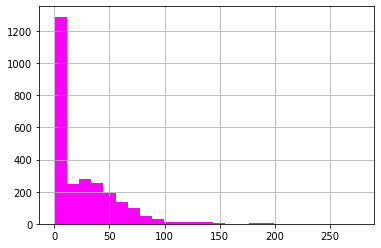

In [88]:
vms['vmsArea'].hist(bins = 25, color = 'magenta')


### Histogram of areas up to 12.5 sqm

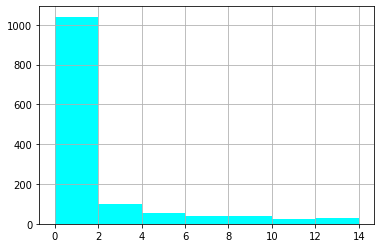

In [89]:
vms['vmsArea'].hist(bins = 7, color = 'cyan', range = (0, 14))

### Choose cut off at 12.5 sqm

Have chosen the car parking size space to be 2.4m by 4.8m. This is the standard UK car parking size, in a UK
public car park. While a smaller car may fit in an area less than this remember than the shape of the space must also be rectangular to fit the shape of a car. Given these two constraints it seems reasonable to drop any manmade surface polygons with area less than the upper bound of 12.5 sqm. 

From the plot below can see that some of these areas are artefacts of the vectorisin of each raster, where any pixel touching was included - hence making some of the pixels lie outside the original cropped garden space.

In [75]:
vms_small = vms[vms.vmsArea.lt(12.5)] #less than 12.5

(393000.0, 393200.0)

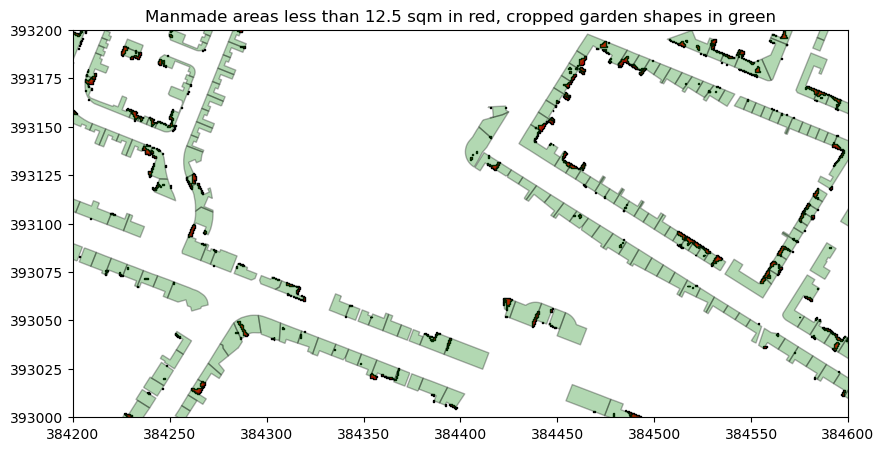

In [77]:
base = vms_small.plot(
    figsize = (10,10), color = 'red', edgecolor = 'black')
cg.plot(ax = base, color = 'green', alpha = 0.3, edgecolor = 'black')
base.set_title(label = "Manmade areas less than 12.5 sqm in red, cropped garden shapes in green")
base.set_xlim(xmin = 384200, xmax = 384600)
base.set_ylim(ymin = 393000, ymax = 393200)

### Drop areas less than 12.5 sqm

- we lose 38 toids completely; these can be classed as no parking
- whittle it away until I'm left with only those that can take parking
- then TOIDs not in that final list are no parking
- left with only those that I want to run final rectangle fitting algorithm on

Have more than one manmade surface vector for a toid, so I need to drop them to reduce the number that are checked with the rectangle fitting algorithm. Then I can compare the remaining list of toids to the original 1329. Which is what I want, so I can see the proportion of residences with parking potential. 

- original list of toids is in cgTOID_list

In [78]:
len(cgTOID_list)

2296

In [95]:
vms = vms[vms.vmsArea.ge(12.5)]

In [96]:
vms.shape

(1326, 3)

In [97]:
vms.nunique()

geometry    1326
TOID        1292
vmsArea      355
dtype: int64

In [98]:
vms.head()

,geometry,TOID,vmsArea
0,"POLYGON ((519575.500 180929.500, 519575.500 18...",1000001778697829,98.25
1,"POLYGON ((519676.500 180895.000, 519676.500 18...",5000005138038971,143.00
2,"POLYGON ((519610.000 180872.000, 519609.500 18...",1000001778697815,72.25
3,"POLYGON ((519075.000 180506.000, 519075.000 18...",1000001778701863,24.25
5,"POLYGON ((519094.500 180526.500, 519094.500 18...",1000001778701877,23.25


In [99]:
rs_ls.head()

,gdnTOID,rsTOID,geometry
0,1000001778708314,1000001778708368,"LINESTRING (519791.500 179998.700, 519790.100 ..."
1,1000001778708315,1000001778708368,"LINESTRING (519795.850 180000.450, 519794.750 ..."
2,1000001778708617,1000001778708368,"LINESTRING (519799.200 180008.550, 519800.450 ..."
3,1000001778708317,1000001778708368,"LINESTRING (519800.450 180005.450, 519801.550 ..."
4,1000001778708000,1000001778708235,"LINESTRING (519590.300 179998.300, 519586.900 ..."


## Overlay VMS with corresponding rs_ls

The vectorised manmade surface polygon must have sufficent length of edge intersecting the roadside linestring, else a car cannot fit into the potential parking area. 

Unfortunately there now exists some overlap between the manmade surface polygons, due to pixels being included if they touched the cropped garden boundary in the jigsaw function. Therefore, to be safe I must interesect each roadside linestring with its corresponding manmade surface polygon/s per TOID (there may be more than one polygon per TOID). Then only keep the VMS that have an interesection with rs_ls geometries greater than 2.4m.



In [82]:
vms.crs = "EPSG:27700"

In [84]:
vms.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [85]:
#initiate list to hold new geometries
vms_rsls = []

#collect list of toids
vms_toid_list = vms.TOID.tolist()

for toid in vms_toid_list:
    
    #overlay on filtered rs_ls and vms
    g = gpd.overlay(
        rs_ls[rs_ls['gdnTOID'] == toid] #LineStrings
        , vms[vms['TOID'] == toid] #Polygons
        , how = 'intersection'
        , keep_geom_type = True #keep geoms the same as df1 geom type
    )
    
    vms_rsls.append(g)

vms_rsls = pd.concat(vms_rsls).reset_index(drop=True)

In [86]:
#select only TOID and new geometry
vms_rsls = vms_rsls[['TOID', 'geometry']]

In [87]:
#drop duplicates
vms_rsls = vms_rsls.drop_duplicates().reset_index(drop=True)

In [88]:
#check geometry types
vms_rsls['geometry'].geom_type.value_counts()

LineString         2645
MultiLineString     213
Name: count, dtype: int64

In [89]:
#check for validity
inv_pol_toid = vms_rsls[ vms_rsls['geometry'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))
#good all valid

0

In [90]:
#see if any multilinestrings can be merged
#use lambda to apply a function to each row of a gdf
vms_rsls['geometry'] = ( 
    vms_rsls['geometry'].apply(lambda x: linemerge(x) if x.geom_type == 'MultiLineString' else x)
)


In [91]:
#this only tidied up a few.
vms_rsls['geometry'].geom_type.value_counts()

LineString         2675
MultiLineString     183
Name: count, dtype: int64

In [92]:
#check for validity
inv_pol_toid = vms_rsls[ vms_rsls['geometry'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))
#good all valid

0

In [93]:
vms_rsls.nunique()

TOID        1943
geometry    2858
dtype: int64

In [94]:
vms_rsls.shape

(2858, 2)

## Investigate duplicate TOIDs

### Duplicates
I think the duplicate geometries arise where there are multiple vms for one TOID being intersected with one roadside linestring. I think it creates the same intersecting geometry for each of them, although that doesn't make sense to still have multiple TOIDs after deduplicating... Will have to check a few multis

Duplicate TOIDs seem to be just separate rows of LineStrings or even MultiLineStrings of roadside edges. I think I can work with this, first 

In [95]:
#Select rows where column value appears more than n times
v = vms_rsls.TOID.value_counts() #create value counts of specified column values

#use v to subset for greater than (gt) n. (less than: lt)
duptoid = vms_rsls[vms_rsls.TOID.isin(v.index[v.gt(1)])].reset_index(drop=True)

In [96]:
duptoid.head()

,TOID,geometry
0,osgb1000000254165409,"LINESTRING (384607.000 393016.008, 384607.013 ..."
1,osgb1000000254165409,"LINESTRING (384607.500 393015.693, 384608.000 ..."
2,osgb1000000254165423,"LINESTRING (384612.500 393008.341, 384613.044 ..."
3,osgb1000000254165423,"LINESTRING (384611.500 393008.968, 384612.000 ..."
4,osgb1000000254166377,"LINESTRING (384595.000 393023.546, 384595.075 ..."


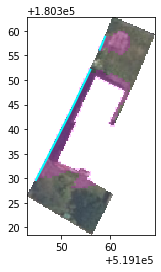

In [113]:
grid = 'TQ1980'
toid = '1000001778714077'

base = duptoid[duptoid['TOID'] == toid].plot(color = 'cyan', linewidth = 2)
vms[vms['TOID'] == toid].plot(ax = base, color = 'magenta', alpha = 0.2)

#get rgb image
rgb_path = '../jigsaw_output/rgb_gdn_cropped/' + grid + "_" + toid + '.tif'
rgb = rasterio.open(rgb_path)

plot.show(rgb, ax = base)

## Explode MultiLineStrings !!!

Even better is explode gdf.explode https://geopandas.org/reference.html

Explode muti-part geometries into multiple single geometries.

Each row containing a multi-part geometry will be split into multiple rows with single geometries, thereby increasing the vertical size of the GeoDataFrame.

The index of the input geodataframe is no longer unique and is replaced with a multi-index (original index with additional level indicating the multiple geometries: a new zero-based index for each single part geometry per multi-part geometry).

Returns
GeoDataFrame
Exploded geodataframe with each single geometry as a separate entry in the geodataframe.

In [98]:
ex_vms_rsls = vms_rsls.explode(index_parts=True)

In [99]:
ex_vms_rsls['geometry'].geom_type.value_counts()

LineString    3082
Name: count, dtype: int64

In [100]:
#check for validity
inv_pol_toid = ex_vms_rsls[ ex_vms_rsls['geometry'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))
#good all valid

0

In [101]:
ex_vms_rsls.shape

(3082, 2)

In [102]:
ex_vms_rsls.nunique()

TOID        1943
geometry    3082
dtype: int64

In [103]:
#Select rows where column value appears more than n times
v = ex_vms_rsls.TOID.value_counts() #create value counts of specified column values

#use v to subset for greater than (gt) n. (less than: lt)
ex_vms_rsls[ex_vms_rsls.TOID.isin(v.index[v.gt(1)])].reset_index(drop=True)

,TOID,geometry
0,osgb1000000254165409,"LINESTRING (384607.000 393016.008, 384607.013 ..."
1,osgb1000000254165409,"LINESTRING (384607.500 393015.693, 384608.000 ..."
2,osgb1000000254165423,"LINESTRING (384612.500 393008.341, 384613.044 ..."
3,osgb1000000254165423,"LINESTRING (384611.500 393008.968, 384612.000 ..."
4,osgb1000000254166377,"LINESTRING (384595.000 393023.546, 384595.075 ..."
...,...,...
1794,osgb5000005277027774,"LINESTRING (384109.418 393794.026, 384109.453 ..."
1795,osgb5000005277027783,"LINESTRING (384109.500 393782.620, 384110.000 ..."
1796,osgb5000005277027783,"LINESTRING (384114.000 393782.678, 384114.626 ..."
1797,osgb5000005288628070,"LINESTRING (384291.500 393329.456, 384291.399 ..."


In [104]:
v

TOID
osgb1000002021025013    14
osgb1000000254202309    12
osgb1000000254190458    11
osgb1000000254203125    10
osgb1000000254196138     9
                        ..
osgb1000000254196622     1
osgb1000000254196615     1
osgb1000000254196609     1
osgb1000000254196606     1
osgb5000005293228288     1
Name: count, Length: 1943, dtype: int64

## Using EXPLODED ex_vms_rsls & drop rows with rslsLength < 2.4m

#CHANGE TO 2.4 M, THIS IS THE WIDTH OF CAR I'M USING SO....
Going to test car sized rectangle of 2.4m wide adjacent to roadside linestring so this length must not be less than 2.4m

- create column of lengths of each individual linestring
- keep only rows with linestring length >= 2.4m

NB exploded version now has a multi index... may want to get rid of this...

In [105]:
ex_vms_rsls['rslsLength'] = ex_vms_rsls['geometry'].length

In [106]:
ex_vms_rsls.sort_values(by = 'rslsLength' ).head()

,,TOID,geometry,rslsLength
1471,0,osgb1000000254202906,"LINESTRING (384138.506 393340.500, 384138.507 ...",0.002136
1166,0,osgb1000000254196620,"LINESTRING (384144.501 393682.500, 384144.500 ...",0.002333
247,0,osgb1000000254190218,"LINESTRING (384762.500 393570.502, 384762.503 ...",0.003804
2607,0,osgb5000005124069981,"LINESTRING (384503.500 393281.002, 384503.505 ...",0.004932
1754,0,osgb1000000254203495,"LINESTRING (384250.000 393119.506, 384250.002 ...",0.005838


### Look at distribution of rslsLength

- justy over 300 are less than 2m, can safely drop these

<Axes: >

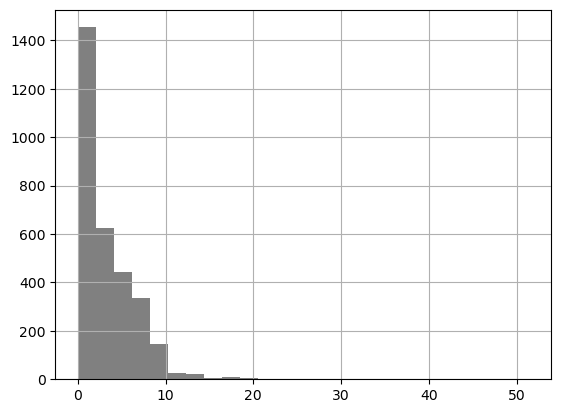

In [107]:
ex_vms_rsls['rslsLength'].hist(bins = 25, color = 'grey')


<Axes: >

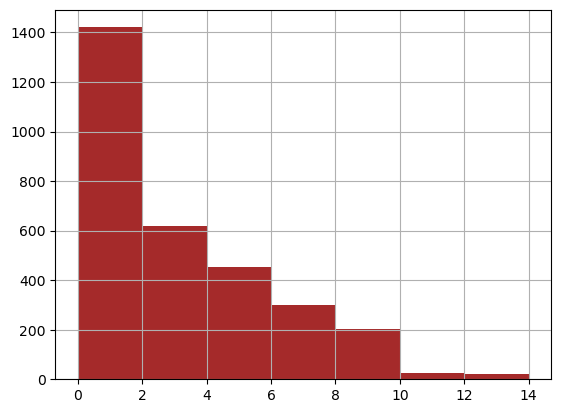

In [108]:
ex_vms_rsls['rslsLength'].hist(bins = 7, color = 'brown', range = (0, 14))

In [109]:
#keep rows with rslsLength >= 2.4m
#rsls24: roadside linestrings greater or equal to 2.4m (24 decimetres)
rsls24 = ex_vms_rsls[ex_vms_rsls.rslsLength.ge(2.4)].reset_index(drop=True)

In [110]:
rsls24.shape

(1495, 3)

In [111]:
rsls24.nunique()

TOID          1394
geometry      1495
rslsLength    1479
dtype: int64

In [112]:
rsls24.head()

,TOID,geometry,rslsLength
0,osgb1000000254165880,"LINESTRING (384622.100 393004.650, 384623.500 ...",2.532586
1,osgb1000000254166184,"LINESTRING (384803.250 393005.860, 384805.320 ...",4.646558
2,osgb1000000254166360,"LINESTRING (384577.000 393034.750, 384581.900 ...",5.771873
3,osgb1000000254166361,"LINESTRING (384581.900 393031.700, 384587.786 ...",6.952645
4,osgb1000000254166377,"LINESTRING (384590.500 393026.315, 384594.500 ...",4.696719


### Filter vms for rsls24 TOIDs

In [113]:
rsls24_list = rsls24.TOID.tolist()

In [114]:
vms = vms[ vms.TOID.isin(rsls24_list) ].reset_index(drop=True)
#df[ df.column.isin(['list', 'of', 'values']) ]

In [115]:
vms.shape

(3011, 3)

In [116]:
vms.nunique()

geometry    3001
TOID        1394
vmsArea      362
dtype: int64

## Look at TOIDs with multiple VMS rows

This example 1000001778702208 is a problem. The parking space has some vegetation over hanging which may appear to be impassable, but actually it is. It's not a hole either but a concave section of the polygon. 

- want to fill in small holes
- also drop small 'bites' ie draw a convex hull around the VMS? 
- might work, might be overkill, end up woith everything fitting, lose all vegetation.
- also convex hull will include the pixels that are just 'touching' and make the polygon yet bigger than it should be.

In [117]:
#Select rows where column value appears more than n times
v = vms.TOID.value_counts() #create value counts of specified column values

#use v to subset for greater than (gt) n. (less than: lt)
duptoid = vms[vms.TOID.isin(v.index[v.gt(1)])].reset_index(drop=True)

In [118]:
duptoid.tail()
#1000001778702208

,geometry,TOID,vmsArea
2220,"POLYGON ((384108.000 393806.500, 384108.000 39...",osgb5000005277027717,34.25
2221,"POLYGON ((384109.500 393783.000, 384109.500 39...",osgb5000005277027783,0.25
2222,"POLYGON ((384114.000 393783.000, 384114.000 39...",osgb5000005277027783,39.75
2223,"POLYGON ((384963.500 393472.500, 384963.500 39...",osgb5000005289146781,0.25
2224,"POLYGON ((384962.500 393475.000, 384962.500 39...",osgb5000005289146781,45.25


<Axes: >

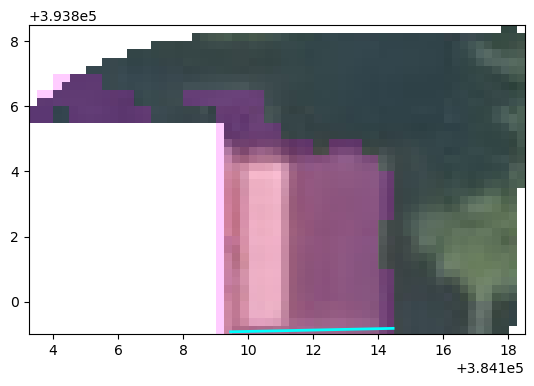

In [119]:
grid = 'M20'
toid = 'osgb5000005277027717'

base = ex_vms_rsls[ex_vms_rsls['TOID'] == toid].plot(color = 'cyan', linewidth = 2)
vms[vms['TOID'] == toid].plot(ax = base, color = 'magenta', alpha = 0.2)

#get rgb image
rgb_path = "C:/Users/Inateck/Documents/parking_provision/off_street_parking/JigsawCroppedRGB/" + grid + "_" + toid + '.tif'
rgb = rasterio.open(rgb_path)

plot.show(rgb, ax = base)

In [120]:
ex_vms_rsls[ex_vms_rsls['TOID'] == toid]

,,TOID,geometry,rslsLength
2840,0,osgb5000005277027717,"LINESTRING (384114.500 393799.177, 384109.421 ...",5.080132


## Fill holes with area <= 1 sqm (4 pixels) in the VMS polygons

- use TOID list from rsls24 (vms only contains polygons with area > 12.5 sqm)
- extract hole linear rings from each vms polygon, create polygon of each hole
- find hole area
- filter for holes <= 1 sqm, these will be filled using 
    - shapely method: unary_union
    - geopandas method: dissolve

https://geopandas.org/aggregation_with_dissolve.html

- collect the holes that have holeArea < 1 sqm, and TOID
- combine into one column of all vms polygons and hole polygons < 1 sqm, another column of TOIDs
- group by TOID and dissolve/unary union
- TOIDs with no holes to merge will attempt to merge with themselves?
- only attempt to merge polygons from TOIDs that occur more than once

In [121]:
vms['geometry'].geom_type.value_counts()

Polygon    3011
Name: count, dtype: int64

### Add interior linear ring lists to vms
The holes are interior linear rings. They have length but no area, they define a boundary inside the exterior ring of the polygon.

In [122]:
vms['intLinRing'] = vms['geometry'].interiors
vms.tail()

,geometry,TOID,vmsArea,intLinRing
3006,"POLYGON ((384970.500 393471.500, 384970.500 39...",osgb5000005289146783,58.50,[]
3007,"POLYGON ((384535.500 393698.000, 384535.500 39...",osgb5000005289254323,44.25,[]
3008,"POLYGON ((384644.000 393665.000, 384644.000 39...",osgb5000005289254326,52.25,[]
3009,"POLYGON ((384999.500 393152.500, 384999.500 39...",osgb5000005290608638,6.75,[]
3010,"POLYGON ((384853.000 393574.500, 384853.000 39...",osgb5000005293228288,20.25,[]


In [123]:
vms.geometry.name

'geometry'

### Convert interior linear ring to polygon to get area

In [124]:
linrings = vms[['TOID', 'intLinRing']]

#TOID is string
# intLinRing is list
linrings.dtypes
#list type
type(linrings['intLinRing'][1])

# explode a column of lists
# https://stackoverflow.com/questions/50217968/pandas-split-list-in-column-into-multiple-rows
# the index matches the index in linrings, so can join TOID back after 
#exlist: exploded list
exlist = ( linrings['intLinRing'].apply(pd.Series).reset_index()
 .melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
 .sort_values(by = 'index')
)

#get column of TOIDs with same index 
toids = linrings[['TOID']]

#left join toids back to exlist on index
hole_pols = exlist.join(toids)

#reset index now I have TOID ids
hole_pols = hole_pols.reset_index()

#convert hole linear rings to polygons
hole_pols['hole_pols'] = ( 
    hole_pols['value']
    .apply(lambda x: shp.geometry.Polygon(list(x.coords)) )
)

#convert to geoDataFrame
hp = gpd.GeoDataFrame(hole_pols, crs="EPSG:27700", geometry="hole_pols")

#create area of hole polygon column
hp['holeArea'] = hp['hole_pols'].area

In [125]:
#check hole_pols area for validity
inv_pol_toid = hp[ hp['hole_pols'].is_valid == False ]['TOID']
len(list(set(inv_pol_toid)))
#good all valid

0

In [126]:
hp.head()

,index,value,TOID,hole_pols,holeArea
0,8,"LINEARRING (384592 393024, 384593 393024, 3845...",osgb1000000254166377,"POLYGON ((384592.000 393024.000, 384593.000 39...",0.50
1,9,"LINEARRING (384597.5 393020.5, 384598 393020.5...",osgb1000000254166420,"POLYGON ((384597.500 393020.500, 384598.000 39...",0.25
2,17,"LINEARRING (384891.5 393815, 384892 393815, 38...",osgb1000000254189928,"POLYGON ((384891.500 393815.000, 384892.000 39...",0.25
3,17,"LINEARRING (384888 393813, 384888.5 393813, 38...",osgb1000000254189928,"POLYGON ((384888.000 393813.000, 384888.500 39...",0.25
4,18,"LINEARRING (384561 393681.5, 384561.5 393681.5...",osgb1000000254189932,"POLYGON ((384561.000 393681.500, 384561.500 39...",0.25


### Look at distribution of hole areas

Difficult to decide the cut off
- 4 pixels is 1 sqm, 8 pixels is 2 sqm
- I feel that 2 sqm is too much, this is a sizeable obstacle.
- 1 sqm, as in 1 * 1 square is also quite a size

Lets just drop 1 sqm holes here, and fill them in

Later we can consider the proportion of intersection between the car parlking sized rectangle and the manmade surface. 
- proportion of overlap
- proportion of remaining manmade surface area

<Axes: >

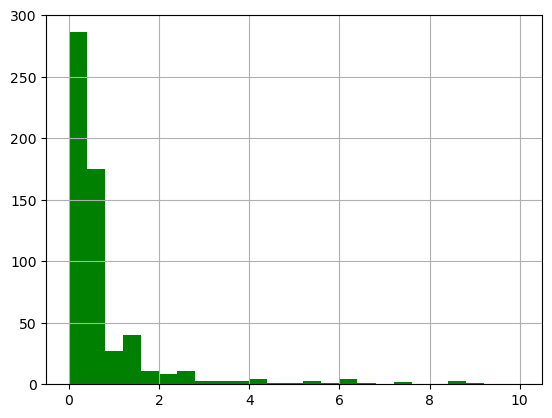

In [127]:
hp['holeArea'].hist(bins = 25, color = 'green', range = (0, 10))

In [128]:
pol = shp.geometry.Polygon(list(hp['value'][0].coords))

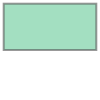

In [129]:
pol

In [130]:
pol.area

0.5

### Collect the holes (and their TOIDs) that have holeArea <= 1 sqm

In [131]:
hp1sqm = hp.query('holeArea <= 1')
#keep only TOID and hole_pols & rename hole_pols to geometry to match VMS
hp1sqm = hp1sqm[['TOID', 'hole_pols']].rename(columns = {'hole_pols' : 'geometry'})

### Combine into one GeoDataFrame with VMS polygons

In [132]:
#p2d: polygons to dissolve
p2d = pd.concat([ vms[['TOID', 'geometry']], hp1sqm ])

In [133]:
hp1sqm.shape[0] + vms.shape[0] == p2d.shape[0]

True

###  Dissolve by TOID

https://geopandas.org/aggregation_with_dissolve.html

We included all the VMS polygons, but some may not have a hole to be dissolved - these will remain the same. However, at this point, **vms** contains only type POLYGON, but has multiple rows for some TOIDS; 999 polygons and 970 TOIDS. 

Dissolving unconnected polygons with the same TOID creates a MULTIPOLYGON - think this will need to be exploded before trying to fit rectangles.

**dhvms** therefore contains all the vectorised manmade surfaces to try to fit rectangle to

In [134]:
#dissolved holes vectorised manmade surfaces
dhvms = p2d.dissolve(by = 'TOID', as_index=False)

In [135]:
dhvms.columns

Index(['TOID', 'geometry'], dtype='object')

In [136]:
#check for validity
print("number of invalid rows: ", dhvms[ dhvms['geometry'].is_valid == False ].shape[0])
#good all valid

number of invalid rows:  0


In [137]:
dhvms.nunique()


TOID        1394
geometry    1394
dtype: int64

### Check dhvms, vms, rsls24

- dhvms: manmade surface area with any holes <= 1sqm filled
- vms: manmade surface area with original holes
- rsls24: roadside linestrings >= 2.4m

Text(0.5, 1, 'The larger hole has not been filled')

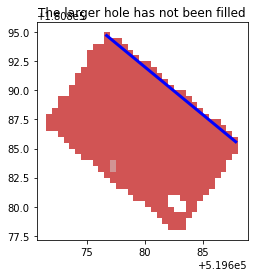

In [156]:
base = vms.query('TOID == "5000005138038971"').plot(color = 'red', alpha = 0.5)
dhvms.query('TOID == "5000005138038971"').plot(ax = base, color = 'brown', alpha = 0.5)
rsls24.query('TOID == "5000005138038971"').plot(color = 'blue', linewidth = 3, ax = base)
base.set_title("The larger hole has not been filled")

## Left join dvhms onto rsls24 by TOID

This should give multiple rows where there are more than one roadside linestring per toid

In [138]:
dhvms.head()

,TOID,geometry
0,osgb1000000254165880,"MULTIPOLYGON (((384632.000 393004.000, 384632...."
1,osgb1000000254166184,"POLYGON ((384805.000 393010.500, 384805.000 39..."
2,osgb1000000254166360,"MULTIPOLYGON (((384572.000 393032.000, 384573...."
3,osgb1000000254166361,"MULTIPOLYGON (((384583.000 393020.000, 384582...."
4,osgb1000000254166377,"MULTIPOLYGON (((384595.000 393022.000, 384594...."


In [139]:
rsls24.head()

,TOID,geometry,rslsLength
0,osgb1000000254165880,"LINESTRING (384622.100 393004.650, 384623.500 ...",2.532586
1,osgb1000000254166184,"LINESTRING (384803.250 393005.860, 384805.320 ...",4.646558
2,osgb1000000254166360,"LINESTRING (384577.000 393034.750, 384581.900 ...",5.771873
3,osgb1000000254166361,"LINESTRING (384581.900 393031.700, 384587.786 ...",6.952645
4,osgb1000000254166377,"LINESTRING (384590.500 393026.315, 384594.500 ...",4.696719


In [140]:
dhvms.nunique()

TOID        1394
geometry    1394
dtype: int64

In [141]:
rsls24.dtypes

TOID            object
geometry      geometry
rslsLength     float64
dtype: object

In [142]:
rsls24.nunique()

TOID          1394
geometry      1495
rslsLength    1479
dtype: int64

In [143]:
#left join dhvms polygons onto rsls24 linestrings
ppp13data = pd.merge(
    left = rsls24
    , right = dhvms
    , how = 'left'
    , on = ['TOID']
    , suffixes=('_rsls', '_vms')
)

In [144]:
ppp13data = ppp13data.set_geometry('geometry_vms')

In [145]:
ppp13data.geometry.name

'geometry_vms'

In [146]:
ppp13data.nunique()

TOID             1394
geometry_rsls    1495
rslsLength       1479
geometry_vms     1394
dtype: int64

In [147]:
ppp13data.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [148]:
type(ppp13data)


geopandas.geodataframe.GeoDataFrame

In [149]:
ppp13data

,TOID,geometry_rsls,rslsLength,geometry_vms
0,osgb1000000254165880,"LINESTRING (384622.100 393004.650, 384623.500 ...",2.532586,"MULTIPOLYGON (((384632.000 393004.000, 384632...."
1,osgb1000000254166184,"LINESTRING (384803.250 393005.860, 384805.320 ...",4.646558,"POLYGON ((384805.000 393010.500, 384805.000 39..."
2,osgb1000000254166360,"LINESTRING (384577.000 393034.750, 384581.900 ...",5.771873,"MULTIPOLYGON (((384572.000 393032.000, 384573...."
3,osgb1000000254166361,"LINESTRING (384581.900 393031.700, 384587.786 ...",6.952645,"MULTIPOLYGON (((384583.000 393020.000, 384582...."
4,osgb1000000254166377,"LINESTRING (384590.500 393026.315, 384594.500 ...",4.696719,"MULTIPOLYGON (((384595.000 393022.000, 384594...."
...,...,...,...,...
1490,osgb5000005289146783,"LINESTRING (384970.750 393471.250, 384978.150 ...",8.207466,"POLYGON ((384970.500 393471.500, 384970.500 39..."
1491,osgb5000005289254323,"LINESTRING (384535.500 393697.877, 384542.366 ...",7.660955,"POLYGON ((384535.500 393698.000, 384535.500 39..."
1492,osgb5000005289254326,"LINESTRING (384649.300 393656.250, 384641.900 ...",8.251212,"POLYGON ((384644.000 393665.000, 384644.000 39..."
1493,osgb5000005290608638,"LINESTRING (384997.800 393150.350, 384998.100 ...",2.851061,"POLYGON ((384999.500 393152.500, 384999.500 39..."


## Plot sense check

Can see from the plot below several issues.

- shadows: sometimes non-vegetation in shadow is counted as vegetation 
- tree canopies: obscure manmade surface below with their legitimate vegetation
- bushes: are flexible so may be passable by a car, but 
- some potential parking spaces have already been dropped as no parking: probably based on lack of roadside linestring intersection with manmade surface, maybe because vms area is less than it should be due to mis-segmentation due to shadows etc. Having too short linestrings also could be an issue.

Will need to calculate several things
- proportion of rectangle area that fits
- proportion of manmade surface area remaining
- ratio of vms area to car parking space size: if large could assume it fits?

In [159]:
#load TQ1980 APGB grids
#path_rgb1980 = r"C:\Users\NicholasJackson\Documents\off_street_parking\Raster\M201AB\120412_20230807\12.5cm Aerial Photo\120412-1_RGB\SJ8493.tif"
#path_irg1980 = r"C:\Users\NicholasJackson\Documents\off_street_parking\Raster\M201AB\120412_20230807\50cm Colour Infrared\120412-3_CIR\SJ8493.tif"

#open
irg1980 = rasterio.open(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Raster\M201AB\120412_20230807\50cm Colour Infrared\120412-3_CIR\SJ8493.tif")
rgb1980 = rasterio.open(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Raster\M201AB\120412_20230807\25cm Aerial Photo\120412-2_RGB\SJ8493.tif")



(393000.0, 393150.0)

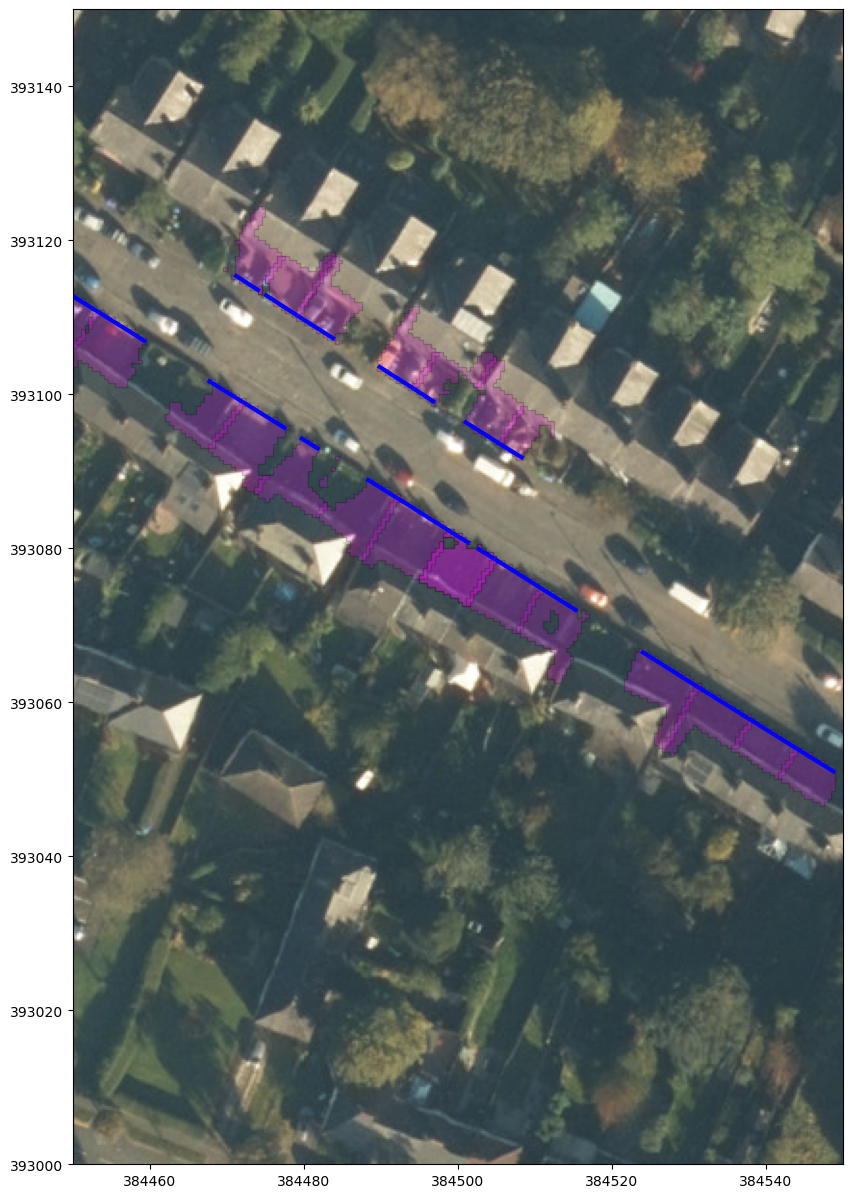

In [170]:
base = ppp13data.plot(figsize = (15,15), color = 'magenta', edgecolor = 'black', linewidth = 1, alpha = 0.2)
rsls24.plot(ax = base, color = 'blue', linewidth = 3)
plot.show(rgb1980, ax = base)
base.set_xlim(xmin = 384450, xmax = 384550)
base.set_ylim(ymin = 393000, ymax = 393150)

(393000.0, 393150.0)

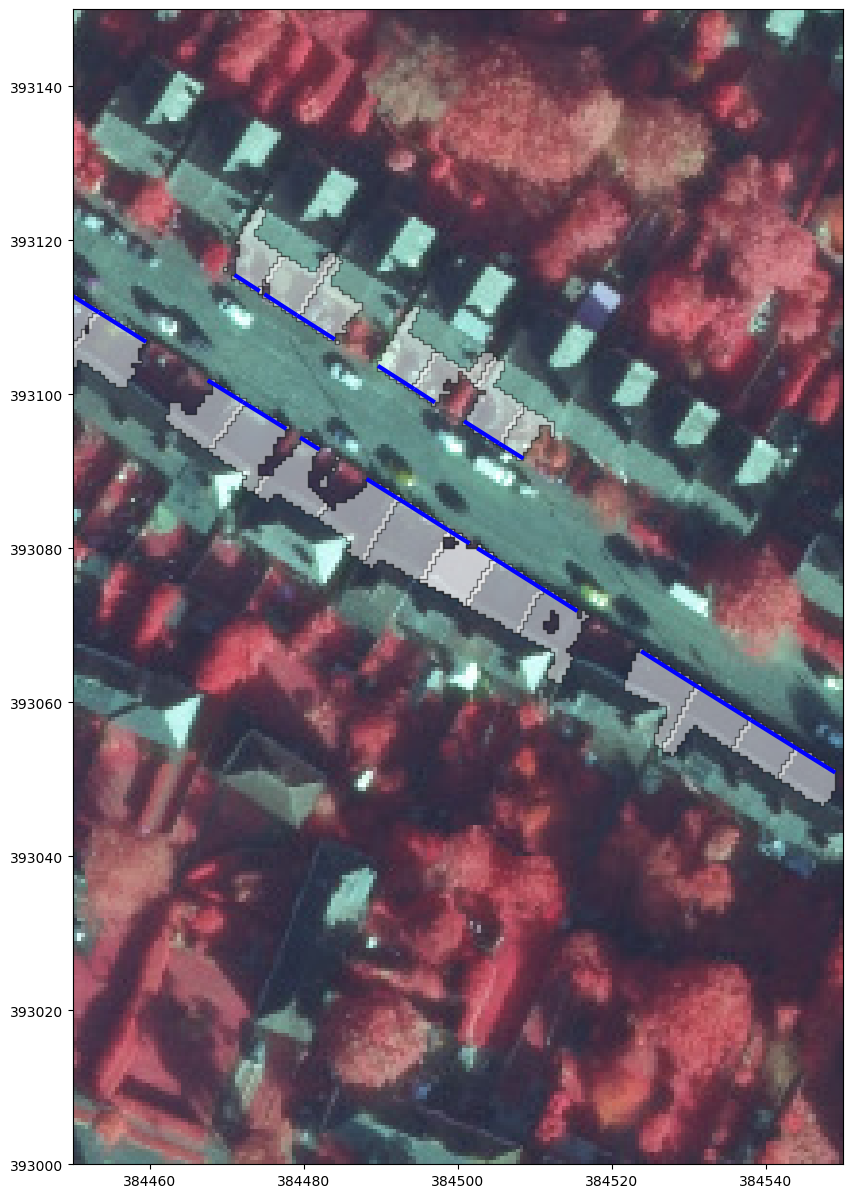

In [169]:
base = ppp13data.plot(figsize = (15,15), color = 'white', edgecolor = 'black', linewidth = 1, alpha = 0.5)
rsls24.plot(ax = base, color = 'blue', linewidth = 3)
plot.show(irg1980, ax = base)
base.set_xlim(xmin = 384450, xmax = 384550)
base.set_ylim(ymin = 393000, ymax = 393150)

### Write data so far

In [161]:
#dissolved holes vms
dhvms.to_file(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Vector\ManmadeSurfaces\dissolvedholesvms.shp")
#roadsidelinestrings >= 2.4m
rsls24.to_file(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Vector\ManmadeSurfaces\roadsidelinestringsG2.shp")

In [165]:
dhvms.head()

,TOID,geometry
0,osgb1000000254165880,"MULTIPOLYGON (((384632.000 393004.000, 384632...."
1,osgb1000000254166184,"POLYGON ((384805.000 393010.500, 384805.000 39..."
2,osgb1000000254166360,"MULTIPOLYGON (((384572.000 393032.000, 384573...."
3,osgb1000000254166361,"MULTIPOLYGON (((384583.000 393020.000, 384582...."
4,osgb1000000254166377,"MULTIPOLYGON (((384595.000 393022.000, 384594...."


In [164]:
#combined dhvms and rsls24 ppp13data
ppp13data.to_csv(r"C:\Users\Inateck\Documents\parking_provision\off_street_parking\Vector\ManmadeSurfaces\combinedDHVMSandRSLS24.csv", index=False)

## No Parking COUNT

Original number of TOIDS = 1329 (0-1328)

No parking count (number of TOIDs)
- (1329 - 1292) = 37 vectorised manmade surfaces too small (less than 12.5 sqm)
- (1292 - 1159) = 133 vectorised manmade surfaces do not intersect with roadside linestring 
- (1159 - 971) = 188 vectorised manmade surfaces have roadside edges less than 2.4m

Total no parking so far: 358


## NEXT

    
#### how to check if car sized rectangle fits...
- rotate image to 'sit' on roadside edge? no good if it goes round a corner or is curved


# ARCHIVE

In [612]:
#get holey polygon
pol = vms.query('TOID == "5000005138038971"')['geom_oriented'].values[0]

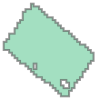

In [613]:
pol

In [614]:
#get holes
h1 = hp.query('TOID == "5000005138038971"')['hole_pols'][0]
h2 = hp.query('TOID == "5000005138038971"')['hole_pols'][1]

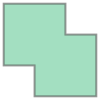

In [615]:
h1

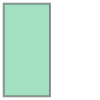

In [616]:
h2

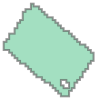

In [617]:
unary_union([pol,  h2])
#good, preserves the other hole

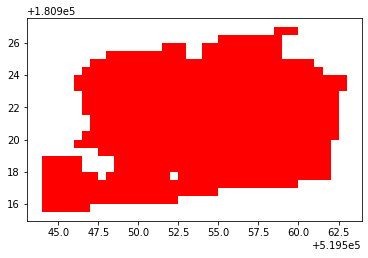

In [692]:
vms.query("TOID == '1000001778697830'").plot(color = 'red')
#HOLES are present now
#plotting using geopandas, via descartes to matplotlib

In [694]:
#1000001778697830
list(vms['geometry'][997].interiors)

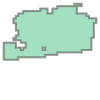

In [695]:
#plotting using shapely
vms['geometry'][997]
#there is clearly a HOLE here !!!!

### Example code to fill all simple holes
https://stackoverflow.com/questions/61427797/filling-a-hole-in-a-multipolygon-with-shapely-netherlands-2-digit-postal-codes

def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

df = df.geometry.apply(lambda p: close_holes(p))

### Holes are interior linear rings
- they do not have area
- they have length
- they mark a boundary inside the polygon

In [561]:
#ilr: interior_linear_rings
#the list of linear rings that give the boundary of anmy holes
#these have length but no area, would have to convert to area
ilr = vms['geometry'].interiors

In [562]:
type(ilr)

pandas.core.series.Series

In [563]:
ilr[0]

[]

In [564]:
#index 0 is a polygon with no holes, hence interior linear ring is empty
len(ilr.values[0])

0

In [565]:
ilr[2]

In [566]:
#each index contains a list, with length equal to the number of holes
len(ilr.values[1])

2

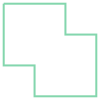

In [567]:
ilr.values[1][0]

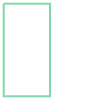

In [568]:
ilr.values[1][1]

## Experiment with a MultiLineString

Looks possible to extract the length of each linestring section in a multilinestring - and therefore keep the largest for comparison to 2m. If the largest is greater than 2 metres then there is access.

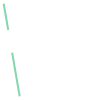

In [183]:
#a MultiLineString made of 2 LineStrings
mls = vms_rsls.geometry[54]
mls

In [184]:
mls.length

6.2104183405865285

In [185]:
len(mls.geoms)

2

In [186]:
#create list of the individual linestring geometries
ls_list = list(mls.geoms)

In [187]:
#access each linestring in the MLS and find its length
ls_list[0].length

2.333916861012527

In [188]:
ls_list[1].length

3.8765014795740016

## BIG PROBLEM - descartes fills holes

Parsing the geopandas geometry to matplotlib uses descartes and doesn't recognise the holes. THEY ARE THERE THOUGH, this method is just not plotting them!!! VERY ANNOYING

https://github.com/geopandas/geopandas/issues/951

https://bitbucket.org/sgillies/descartes/issues/3/plotting-issue-with-interior-polygons

### Fix by reversing the order of the interior rings

Creating a new polygon from the old one, and only inverting the order of the coordinates of the interior, and plotting it then again, indeed gives the desired result:

polygon = gdf.squeeze()
exterior = polygon.exterior
interior = list(polygon.interiors)[0]
from shapely.geometry import Polygon
polygon2 = Polygon(exterior, [[c for c in list(interior.coords)[::-1]]])

gdf2 = geopandas.GeoDataFrame(geometry=[polygon2])
gdf2.plot()

### shapely.geometry.polygon.orient 
Since the orientation of the exterior ring doesn't matter, you could use the shapely.geometry.polygon.orient function, which will orient the interiors clockwise or counterclockwise.

https://gis.stackexchange.com/questions/318423/how-to-inverse-the-orientation-of-the-holes-coordinates-of-a-polygon-in-geopanda/318430

shapely.geometry.polygon.orient(polygon, sign=1.0)
Returns a properly oriented copy of the given polygon. The signed area of the result will have the given sign. A sign of 1.0 means that the coordinates of the product’s exterior ring will be oriented counter-clockwise and the interior rings (holes) will be oriented clockwise.


## FIX:

In [603]:
#new_geometry_series = dataframe.geometry.apply(polygon.orient,args=(1)) #or -1
vms['geom_oriented'] = (
    vms['geometry'].apply(lambda x: shp.geometry.polygon.orient(x, 1))
)

In [ ]:
pol = shp.geometry.Polygon(list(hole_pols['value'][0].coords))

## Other links

file:///Users/tamsinforbes/Documents/MSc_DS/ECMM433_Project_1/bibliography_tech_specs/opencv-python-tutroals-readthedocs-io-en-latest.pdf

http://people.csail.mit.edu/sparis/bf_course/

http://www.ccpo.odu.edu/SEES/veget/vg_class.htm

http://www.ccpo.odu.edu/SEES/veget/class/Chap_3/index.htm

http://www.cmm.mines-paristech.fr/~beucher/wtshed.html



In [127]:
#Red channel - manmade surfac including external garden area
#make manmade (<=0) 255 and everything else 0 using copy of veg
#and inverting it
man = (veg.copy() - 255) * -1

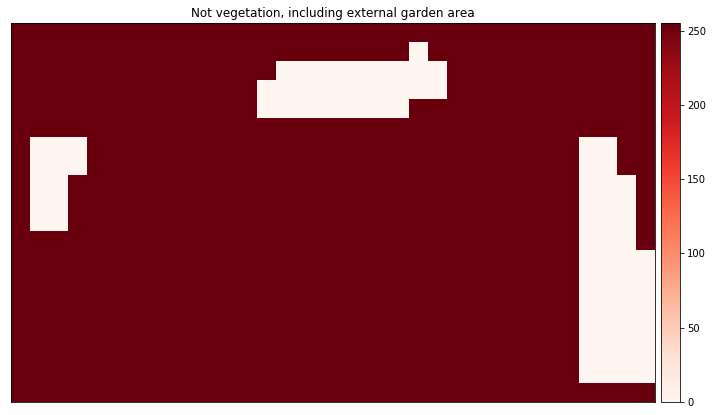

In [128]:
ep.plot_bands(man
              , cmap='Reds'
              , scale=False
              , title="Not vegetation, including external garden area")
plt.show()

## Reshaping np arrays

In [86]:
r = np.ones((4, 5), dtype=int)
s = 2 * r
t = 3 * r

In [87]:
d = np.dstack((r,s,t))
d.shape

(4, 5, 3)

In [88]:
d

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

In [180]:
v = np.vstack((r,s,t))
v.shape
v


array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3]])

In [158]:
new = np.reshape(v, (3,4,5), 'C' )
new.shape
new[0]

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [181]:
v = np.reshape(v, (3,4,5), 'C' )
v.shape
v[0]

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])